## <u> Multi-seed Evaluation over River Discharge Study </u>

### <u>Import libraries, modules and models </u>

In [1]:
# Import main libraries
import os, sys
import seaborn as sns
import torch
import numpy as np
import pandas as pd
from matplotlib.dates import DateFormatter, DayLocator
import matplotlib.dates as mdates
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
from matplotlib.ticker import MultipleLocator, AutoMinorLocator


# Set current and repository working directory
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import custom modules
from Modules.multi_seed import *


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### <u>Import dataset:</u>

In [2]:
# Import dataset and split into train-validation and test sets
df = pd.read_csv("../River_Discharge_Study/tilde_X.csv", index_col=0, parse_dates=True)
df_train_val = df[:10349]
df_test = df[10349:]
lag=10
feature=df.shape[1]
val_size = 0.25
batch_size = 256

In [3]:
df_train_val.head(2)

,Gsteig_Q,BEP,GHS,THU,LTB,BRZ,MER,Schonau_Q
Date,,,,,,,,
1930-01-01,3.6,0.0,0.0,0.0,0.8,1.3,0.5,46.1
1930-01-02,3.6,3.2,0.5,2.3,1.0,3.4,3.2,46.1


In [4]:
df_test.head(2)

,Gsteig_Q,BEP,GHS,THU,LTB,BRZ,MER,Schonau_Q
Date,,,,,,,,
1958-05-03,26.5,0.0,0.0,0.0,0.0,0.0,0.0,165.0
1958-05-04,28.3,0.0,0.0,0.0,0.0,0.0,0.0,167.0


### <u>Multi seeds evaluation:</u>

In [5]:
# results_df_rd, predictions = evaluate_models_multiple_seeds(
#     df_train_val=df_train_val,
#     df_test=df_test,
#     experiment_type='river',
#     lags=10,
#     val_size=val_size,
#     batch_size=batch_size,
#     seeds=list(range(2, 12)), 
#     true_quantiles_df=None,
#     results_path="river_discharge_multi_seed_results_final",
#     device=device
# )

In [6]:
# Compute summary statistics across seeds
results_df_rd = pd.read_csv("river_discharge_multi_seed_results_final_multiseed_evaluation_20251102_204231.csv")

In [7]:

# ============================================
# RIVER DISCHARGE RESULTS AGGREGATION
# ============================================
print("\n" + "="*80)
print("RIVER DISCHARGE STUDY RESULTS (Mean ± Std across 10 seeds)")
print("="*80)

# Define metrics to aggregate
# Note: NO quantile metrics since true_quantiles_df=None for river discharge
metrics = ['rmse', 'upperquantile_rmse', 'energy_loss', 
           'picp_80', 'sharpness_80', 'duration_sec']

# Aggregate
summary_rd = results_df_rd.groupby('model_name')[metrics].agg(['mean', 'std'])

# Reorder models
ordered_models = ['mlp', 'sequential_mlp', 'engression', 'h_engression', 
                  'sequential_engression', 'h_sequential_engression']
summary_rd = summary_rd.reindex(ordered_models)

# Display with formatting
pd.options.display.float_format = '{:.6f}'.format
summary_rd


RIVER DISCHARGE STUDY RESULTS (Mean ± Std across 10 seeds)


rmse          upperquantile_rmse           \
                             mean      std               mean      std   
model_name                                                               
mlp                     11.134881 0.082866          27.956887 0.991271   
sequential_mlp          11.418080 0.195940          45.581709 3.194938   
engression              10.315247 0.074498          24.549556 0.766885   
h_engression            10.252265 0.103794          25.386323 0.718255   
sequential_engression   10.625787 0.298177          40.461769 2.847756   
h_sequential_engression 10.434705 0.151138          36.633484 2.843031   

                        energy_loss           picp_80          sharpness_80  \
                               mean      std     mean      std         mean   
model_name                                                                    
mlp                             NaN      NaN      NaN      NaN          NaN   
sequential_mlp                  NaN      NaN      NaN      NaN          NaN   
engression                 4.810884 0.053865 0.811761 0.008688    19.385448   
h_engression               4.770130 0.046247 0.790593 0.012858    18.181835   
sequential_engression      4.830530 0.158725 0.817281 0.013485    19.280955   
h_sequential_engression    4.694982 0.086142 0.806956 0.015443    18.641223   

                                 duration_sec            
                             std         mean       std  
model_name                                               
mlp                          NaN    33.809756  2.873880  
sequential_mlp               NaN    52.843432  9.167417  
engression              0.535857    57.528473  5.462695  
h_engression            0.711071    54.155110  7.119056  
sequential_engression   1.170811    97.095051 22.370558  
h_sequential_engression 0.931650    96.406798 11.643607

### <u>Multi seeds plots:</u>

#### <u>**Determististic model**</u>

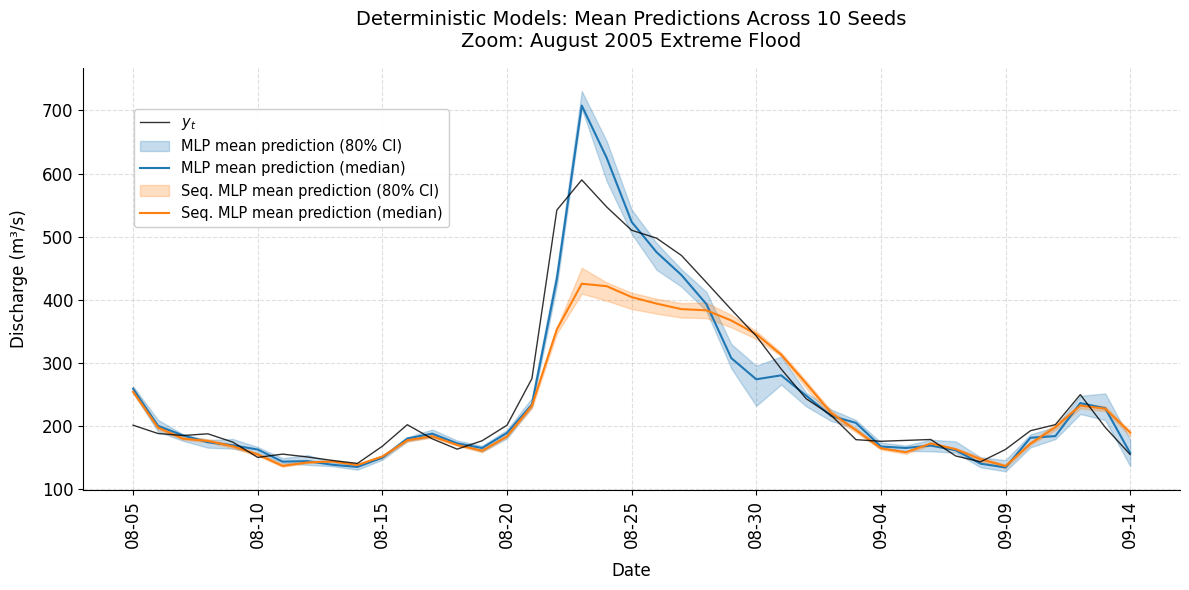

In [8]:
with open('river_discharge_multi_seed_results_final_predictions_20251102_204231.pkl', 'rb') as f:
    data = pickle.load(f)

predictions = data['predictions']
seeds = data['experiment_info']['seeds']

# Window around 2005 peak
start, window = 17251, 41
end = start + window

# Get dates (add back test start index 10349 and lags 10)
data_start = start + 10349 + 10
plot_dates = df.index[data_start:data_start+window]

# Extract MLP predictions
mlp_preds = []
y_true = None
for seed in seeds:
    key = f'mlp_seed{seed}'
    if key in predictions:
        mlp_preds.append(predictions[key]['y_pred'][start:end])
        if y_true is None:
            y_true = predictions[key]['y_true'][start:end]

mlp_preds = np.array(mlp_preds).T

# Extract Sequential MLP predictions  
seq_mlp_preds = []
for seed in seeds:
    key = f'sequential_mlp_seed{seed}'
    if key in predictions:
        seq_mlp_preds.append(predictions[key]['y_pred'][start:end])

seq_mlp_preds = np.array(seq_mlp_preds).T

# Compute statistics across seeds
mlp_median = np.median(mlp_preds, axis=1)
mlp_q10 = np.percentile(mlp_preds, 10, axis=1)
mlp_q90 = np.percentile(mlp_preds, 90, axis=1)

seq_median = np.median(seq_mlp_preds, axis=1)
seq_q10 = np.percentile(seq_mlp_preds, 10, axis=1)
seq_q90 = np.percentile(seq_mlp_preds, 90, axis=1)

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(plot_dates, y_true, linewidth=1, label='$y_t$', zorder=11, alpha=0.8,
        color='black')

ax.fill_between(plot_dates, mlp_q10, mlp_q90, alpha=0.25, color='#1f77b4', 
                label='MLP mean prediction (80% CI)', zorder=3)
ax.plot(plot_dates, mlp_median, color='#1f77b4', linewidth=1.5, 
        label='MLP mean prediction (median)', zorder=5)

ax.fill_between(plot_dates, seq_q10, seq_q90, alpha=0.25, color='#ff7f0e', 
                label='Seq. MLP mean prediction (80% CI)', zorder=3)
ax.plot(plot_dates, seq_median, color='#ff7f0e', linewidth=1.5, 
        label='Seq. MLP mean prediction (median)', zorder=5)

ax.set_xlabel('Date', fontsize=12, labelpad=10)
ax.set_ylabel('Discharge (m³/s)', fontsize=12, labelpad=10)
ax.set_title('Deterministic Models: Mean Predictions Across 10 Seeds\nZoom: August 2005 Extreme Flood', 
             fontsize=14, pad=15)
ax.grid(True, alpha=0.4, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set explicit ticks: every 5 days, starting from first date
tick_indices = np.arange(0, len(plot_dates), 5)
ax.set_xticks(plot_dates[tick_indices])
ax.xaxis.set_major_formatter(DateFormatter('%m-%d'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90, ha='center')
ax.tick_params(axis='both', labelsize=12)

current_ylim = ax.get_ylim()
y_range = current_ylim[1] - current_ylim[0]
ax.set_ylim(current_ylim[0], current_ylim[1] + 0.01 * y_range)

ax.legend(loc='upper left', fontsize=10.5, framealpha=0.95, bbox_to_anchor=(0.04, 0.92))

plt.tight_layout()
plt.savefig('deterministic_river_comparison.pdf', bbox_inches='tight', dpi=300)
plt.show()

#### <u>**Stochastic model with mean prediction**</u>

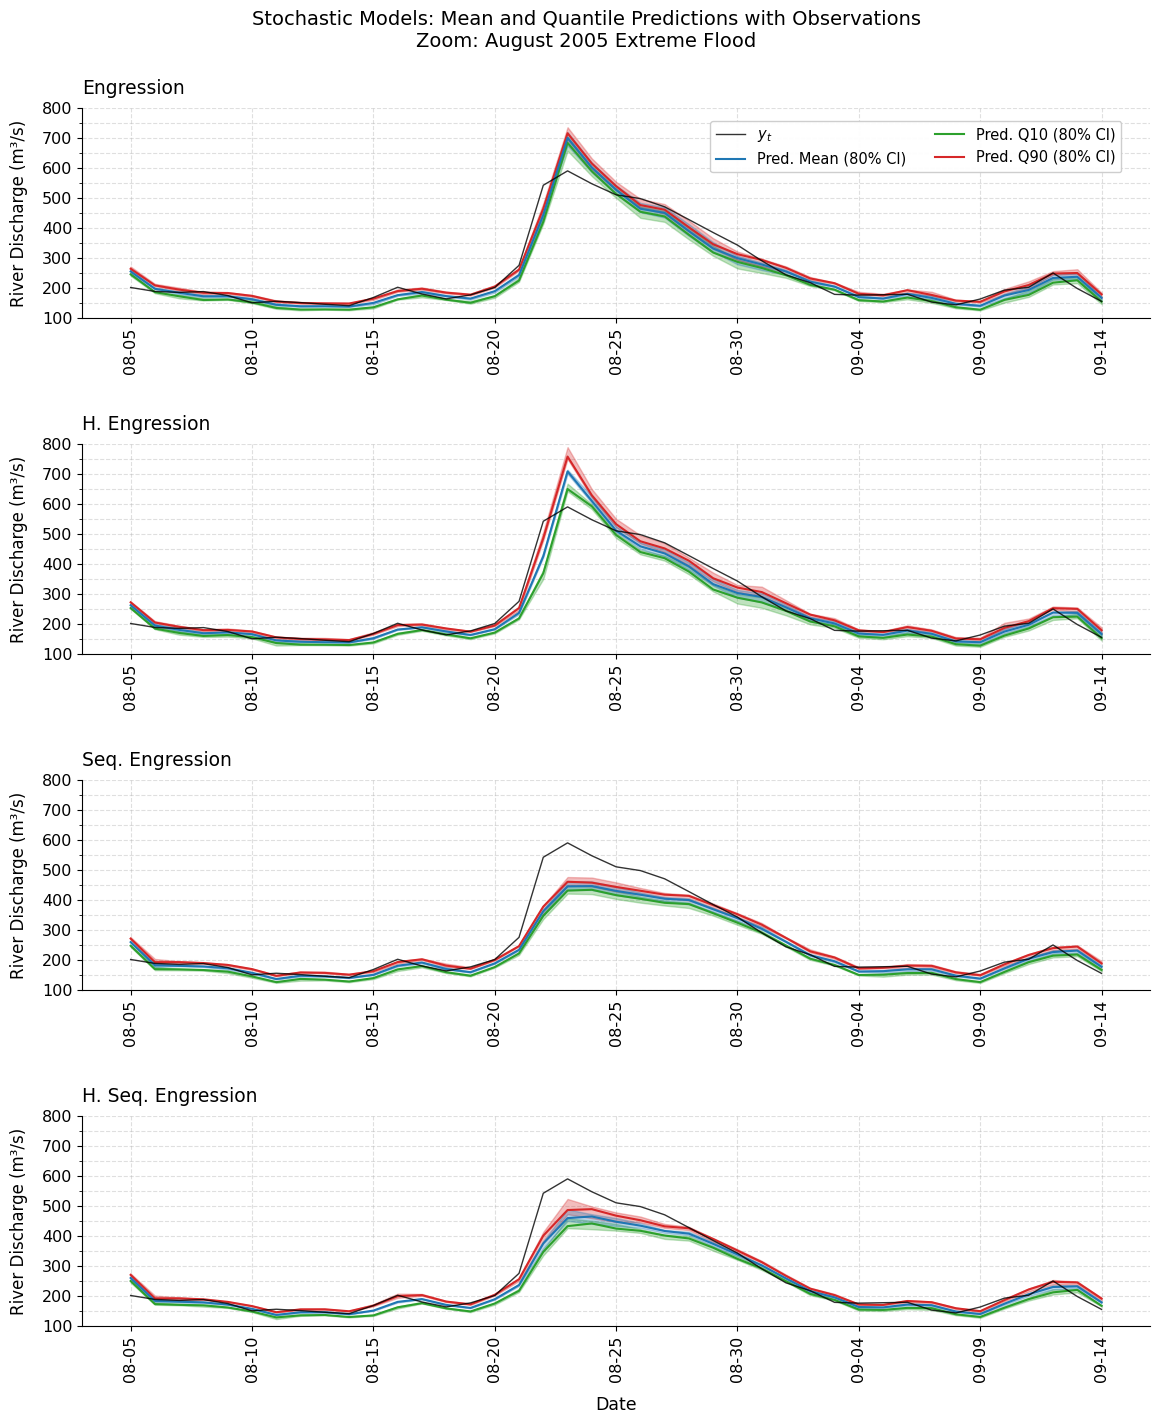

In [9]:
# Window around 2005 peak
start, window = 17251, 41
end = start + window

# Get dates (add back test start index 10349 and lags 10)
data_start = start + 10349 + 10
plot_dates = df.index[data_start:data_start+window]

# Define model configurations
models = [
    ('engression', 'Engression'),
    ('h_engression', 'H. Engression'),
    ('sequential_engression', 'Seq. Engression'),
    ('h_sequential_engression', 'H. Seq. Engression')
]

# Extract true observations (same for all models)
y_true = None

# Create subplots with equal height ratios
fig = plt.figure(figsize=(12, 14))
gs = fig.add_gridspec(4, 1, height_ratios=[1, 1, 1, 1], hspace=0.6, 
                      left=0.08, right=0.97, top=0.92, bottom=0.05)
axes = [fig.add_subplot(gs[i]) for i in range(4)]

for idx, (model_key, model_name) in enumerate(models):
    ax = axes[idx]
    
    # Extract predictions across all seeds for this model
    mean_preds = []
    q10_preds = []
    q90_preds = []
    
    for seed in seeds:
        key = f'{model_key}_seed{seed}'
        if key in predictions:
            pred_data = predictions[key]
            
            # Extract mean prediction and quantile predictions
            if 'y_pred' in pred_data:
                mean_slice = pred_data['y_pred'][start:end]
                mean_preds.append(np.asarray(mean_slice).ravel())
            if 'y_pred_q10' in pred_data:
                q10_slice = pred_data['y_pred_q10'][start:end]
                q10_preds.append(np.asarray(q10_slice).ravel())
            if 'y_pred_q90' in pred_data:
                q90_slice = pred_data['y_pred_q90'][start:end]
                q90_preds.append(np.asarray(q90_slice).ravel())
            
            # Extract observations 
            if y_true is None and 'y_true' in pred_data:
                y_true = np.asarray(pred_data['y_true'][start:end]).ravel()
    
    # Check if we have data
    if len(mean_preds) == 0 or len(q10_preds) == 0 or len(q90_preds) == 0:
        print(f"Warning: No data found for {model_name}")
        continue
    
    # Stack arrays and compute statistics
    mean_preds = np.vstack(mean_preds)
    q10_preds = np.vstack(q10_preds)
    q90_preds = np.vstack(q90_preds)
    
    # For mean predictions: compute median across seeds and 80% CI
    mean_median = np.median(mean_preds, axis=0).ravel()
    mean_lower = np.percentile(mean_preds, 10, axis=0).ravel()
    mean_upper = np.percentile(mean_preds, 90, axis=0).ravel()
    
    # For quantiles: compute median across seeds and 80% CI
    q10_median = np.median(q10_preds, axis=0).ravel()
    q10_lower = np.percentile(q10_preds, 10, axis=0).ravel()
    q10_upper = np.percentile(q10_preds, 90, axis=0).ravel()
    
    q90_median = np.median(q90_preds, axis=0).ravel()
    q90_lower = np.percentile(q90_preds, 10, axis=0).ravel()
    q90_upper = np.percentile(q90_preds, 90, axis=0).ravel()
    
    # Plot observed values (black line)
    if y_true is not None:
        ax.plot(plot_dates, y_true, color='black', linewidth=1.0, alpha=0.8,
                markersize=2, label='$y_t$', zorder=11)
    
    # Plot predicted mean with 80% CI - Blue
    ax.fill_between(plot_dates, mean_lower, mean_upper, alpha=0.3, color='#1f77b4', 
                    zorder=3)
    ax.plot(plot_dates, mean_median, color='#1f77b4', linewidth=1.5, 
            label='Pred. Mean (80% CI)', zorder=5)
    
    # 10% quantile - Green
    ax.fill_between(plot_dates, q10_lower, q10_upper, alpha=0.3, color='#2ca02c', 
                    zorder=2)
    ax.plot(plot_dates, q10_median, color='#2ca02c', linewidth=1.5, 
            label='Pred. Q10 (80% CI)', zorder=4)
    
    # 90% quantile - Red
    ax.fill_between(plot_dates, q90_lower, q90_upper, alpha=0.3, color='#d62728', 
                    zorder=2)
    ax.plot(plot_dates, q90_median, color='#d62728', linewidth=1.5, 
            label='Pred. Q90 (80% CI)', zorder=4)
    
    # Formatting
    if idx == 3:  # Only bottom plot
        ax.set_xlabel('Date', fontsize=12.5, labelpad=10)
    ax.set_ylabel('River Discharge (m³/s)', fontsize=12, labelpad=10)
    ax.set_title(model_name, fontsize=13.5, pad=10, fontweight='normal', loc='left')
    
    # Grid with custom spacing
    ax.set_axisbelow(True)  # Put grid behind data
    ax.grid(True, which='major', alpha=0.4, linestyle='--')
    ax.grid(True, which='minor', alpha=0.4, linestyle='--')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    
    # Date formatting
    tick_indices = np.arange(0, len(plot_dates), 5)
    ax.set_xticks(plot_dates[tick_indices])
    ax.xaxis.set_major_formatter(DateFormatter('%m-%d'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90, ha='center')
    ax.tick_params(axis='both', labelsize=11.5)
    
    # Y-axis: major ticks every 100 (with labels), minor ticks every 50 (gridlines only)
    ax.set_ylim(100, 800)
    ax.yaxis.set_major_locator(MultipleLocator(100))  
    ax.yaxis.set_minor_locator(MultipleLocator(50))   
    
    # Add legend only to first subplot
    if idx == 0:
        ax.legend(loc='upper right', fontsize=10.5, framealpha=0.95, ncol=2, 
                 bbox_to_anchor=(0.98, 0.97))

# Add overall title
fig.suptitle('Stochastic Models: Mean and Quantile Predictions with Observations\nZoom: August 2005 Extreme Flood', 
             fontsize=14, y=0.99, fontweight='normal')

plt.savefig('stochastic_river_quantiles_mean.pdf', bbox_inches='tight', dpi=600)
plt.show()

#### <u>**Stochastic model with median prediction**</u>

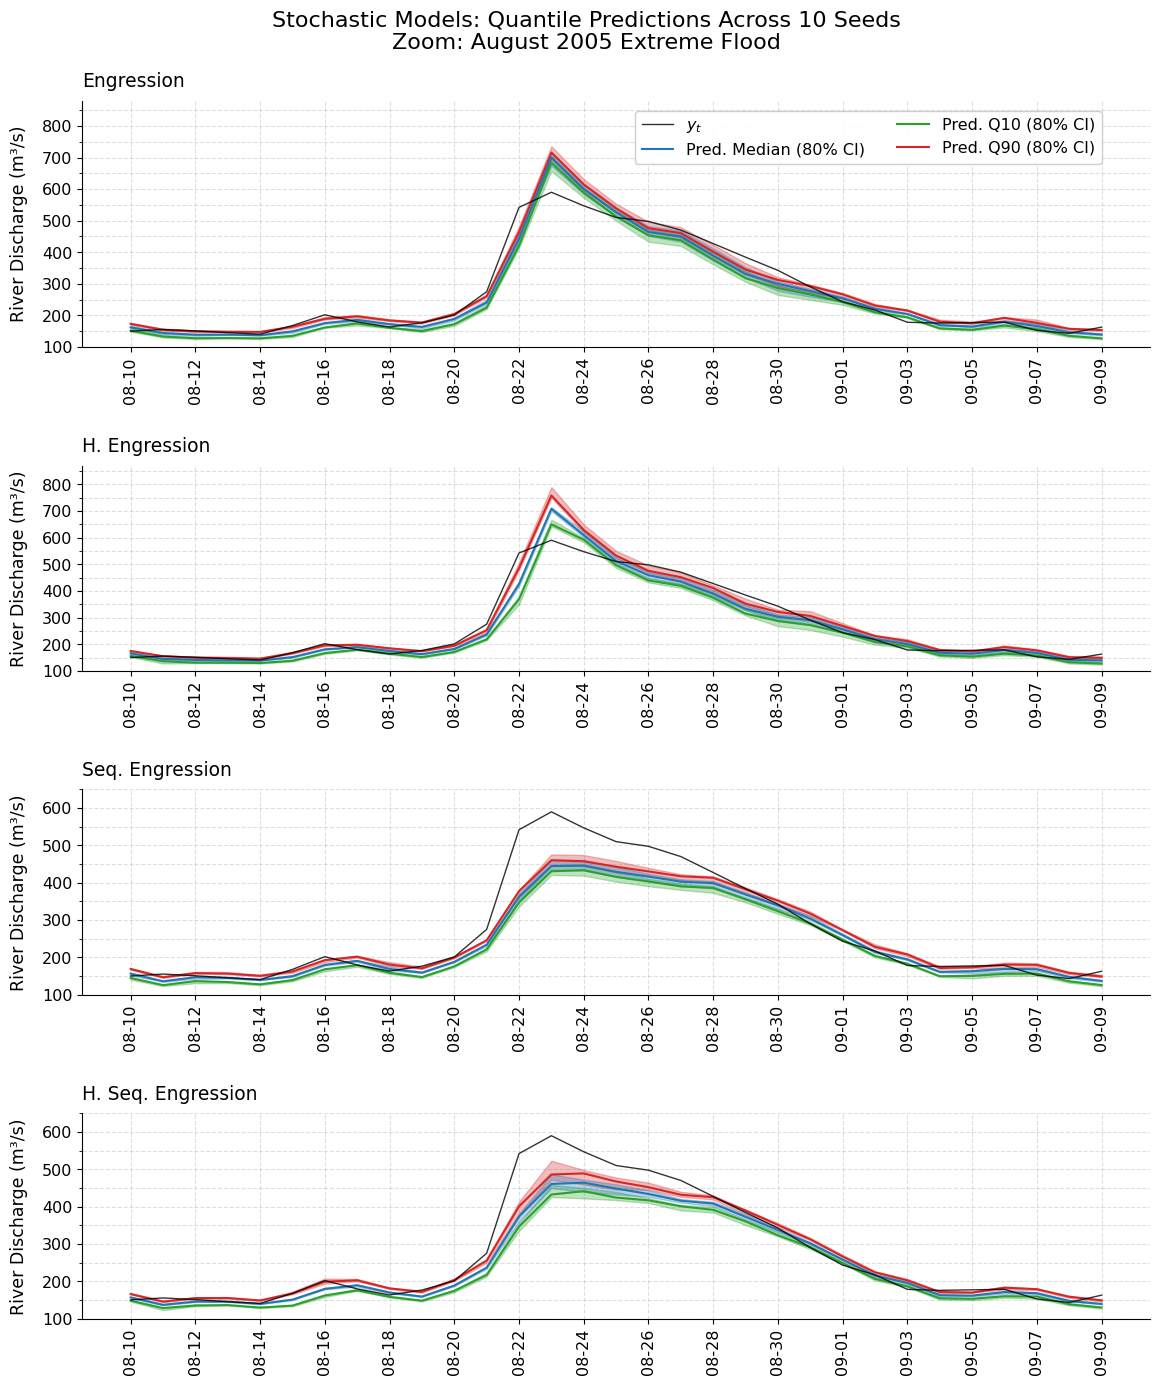

In [10]:
# Window around 2005 peak
start, window = 17256, 31
end = start + window

# Get dates (add back test start index 10349 and lags 10)
data_start = start + 10349 + 10
plot_dates = df.index[data_start:data_start+window]

# Define model configurations
models = [
    ('engression', 'Engression'),
    ('h_engression', 'H. Engression'),
    ('sequential_engression', 'Seq. Engression'),
    ('h_sequential_engression', 'H. Seq. Engression')
]

# Extract true observations (same for all models)
y_true = None

# Create subplots with equal height ratios
fig = plt.figure(figsize=(12, 14))
gs = fig.add_gridspec(4, 1, height_ratios=[1.2, 1, 1, 1], hspace=0.55, 
                      left=0.08, right=0.97, top=0.92, bottom=0.05)
axes = [fig.add_subplot(gs[i]) for i in range(4)]

for idx, (model_key, model_name) in enumerate(models):
    ax = axes[idx]
    
    # Extract predictions across all seeds for this model
    q10_preds = []
    q50_preds = []
    q90_preds = []
    
    for seed in seeds:
        key = f'{model_key}_seed{seed}'
        if key in predictions:
            pred_data = predictions[key]
            
            # Extract quantile predictions
            if 'y_pred_q10' in pred_data:
                q10_slice = pred_data['y_pred_q10'][start:end]
                q10_preds.append(np.asarray(q10_slice).ravel())
            if 'y_pred_median' in pred_data:
                q50_slice = pred_data['y_pred_median'][start:end]
                q50_preds.append(np.asarray(q50_slice).ravel())
            if 'y_pred_q90' in pred_data:
                q90_slice = pred_data['y_pred_q90'][start:end]
                q90_preds.append(np.asarray(q90_slice).ravel())
            
            # Extract observations 
            if y_true is None and 'y_true' in pred_data:
                y_true = np.asarray(pred_data['y_true'][start:end]).ravel()
    
    # Check if we have data
    if len(q10_preds) == 0 or len(q50_preds) == 0 or len(q90_preds) == 0:
        print(f"Warning: No data found for {model_name}")
        continue
    
    # Stack arrays and compute statistics
    q10_preds = np.vstack(q10_preds)
    q50_preds = np.vstack(q50_preds)
    q90_preds = np.vstack(q90_preds)
    
    # Compute median across seeds and 80% CI
    q10_median = np.median(q10_preds, axis=0).ravel()
    q10_lower = np.percentile(q10_preds, 10, axis=0).ravel()
    q10_upper = np.percentile(q10_preds, 90, axis=0).ravel()
    
    q50_median = np.median(q50_preds, axis=0).ravel()
    q50_lower = np.percentile(q50_preds, 10, axis=0).ravel()
    q50_upper = np.percentile(q50_preds, 90, axis=0).ravel()
    
    q90_median = np.median(q90_preds, axis=0).ravel()
    q90_lower = np.percentile(q90_preds, 10, axis=0).ravel()
    q90_upper = np.percentile(q90_preds, 90, axis=0).ravel()
    
    # Plot observed values (gray line)
    if y_true is not None:
        ax.plot(plot_dates, y_true, color='black', linewidth=1.0, alpha=0.8,
                markersize=2, label='$y_t$', zorder=11)
    
    # Plot predicted quantiles with 80% CI
    # Median (q50) - Blue
    ax.fill_between(plot_dates, q50_lower, q50_upper, alpha=0.3, color='#1f77b4', 
                    zorder=3)
    ax.plot(plot_dates, q50_median, color='#1f77b4', linewidth=1.5, 
            label='Pred. Median (80% CI)', zorder=5)
    
    # 10% quantile - Green
    ax.fill_between(plot_dates, q10_lower, q10_upper, alpha=0.3, color='#2ca02c', 
                    zorder=2)
    ax.plot(plot_dates, q10_median, color='#2ca02c', linewidth=1.5, 
            label='Pred. Q10 (80% CI)', zorder=4)
    
    # 90% quantile - Red
    ax.fill_between(plot_dates, q90_lower, q90_upper, alpha=0.3, color='#d62728', 
                    zorder=2)
    ax.plot(plot_dates, q90_median, color='#d62728', linewidth=1.5, 
            label='Pred. Q90 (80% CI)', zorder=4)
    
    ax.set_ylabel('River Discharge (m³/s)', fontsize=12.5, labelpad=10)
    ax.set_title(model_name, fontsize=13.5, pad=10, fontweight='normal', loc='left')
    
    # Grid with custom spacing
    ax.set_axisbelow(True)
    ax.grid(True, which='major', alpha=0.4, linestyle='--')
    ax.grid(True, which='minor', alpha=0.4, linestyle='--')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    
    # Date formatting
    tick_indices = np.arange(0, len(plot_dates), 2)
    ax.set_xticks(plot_dates[tick_indices])
    ax.xaxis.set_major_formatter(DateFormatter('%m-%d'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90, ha='center')
    ax.tick_params(axis='both', labelsize=11.5)
    
    # Flexible y-axis limits based on data, with grid structure
    # Find data range for this subplot
    all_data = np.concatenate([y_true, q10_lower, q10_upper, q50_lower, q50_upper, 
                                q90_lower, q90_upper])
    data_min = np.min(all_data)
    data_max = np.max(all_data)
    
    # Round to nearest 50 for clean limits
    y_min = np.floor(data_min / 50) * 50
    y_max = np.ceil(data_max / 50) * 50
    
    # Add padding
    y_range = y_max - y_min
    if idx == 0:  
        y_max += 0.2 * y_range
    else:
        y_max += 0.1 * y_range

    ax.set_ylim(y_min, y_max)
    ax.yaxis.set_major_locator(MultipleLocator(100))  
    ax.yaxis.set_minor_locator(MultipleLocator(50))
    
    # Add legend only to first subplot
    if idx == 0:
        ax.legend(loc='upper right', fontsize=11.5, framealpha=0.95, ncol=2, 
                 bbox_to_anchor=(0.962, 0.99))

# Add overall title
fig.suptitle('Stochastic Models: Quantile Predictions Across 10 Seeds\nZoom: August 2005 Extreme Flood', 
             fontsize=16, y=0.985, fontweight='normal')

plt.savefig('stochastic_river_quantiles_median.pdf', bbox_inches='tight', dpi=600)
plt.show()

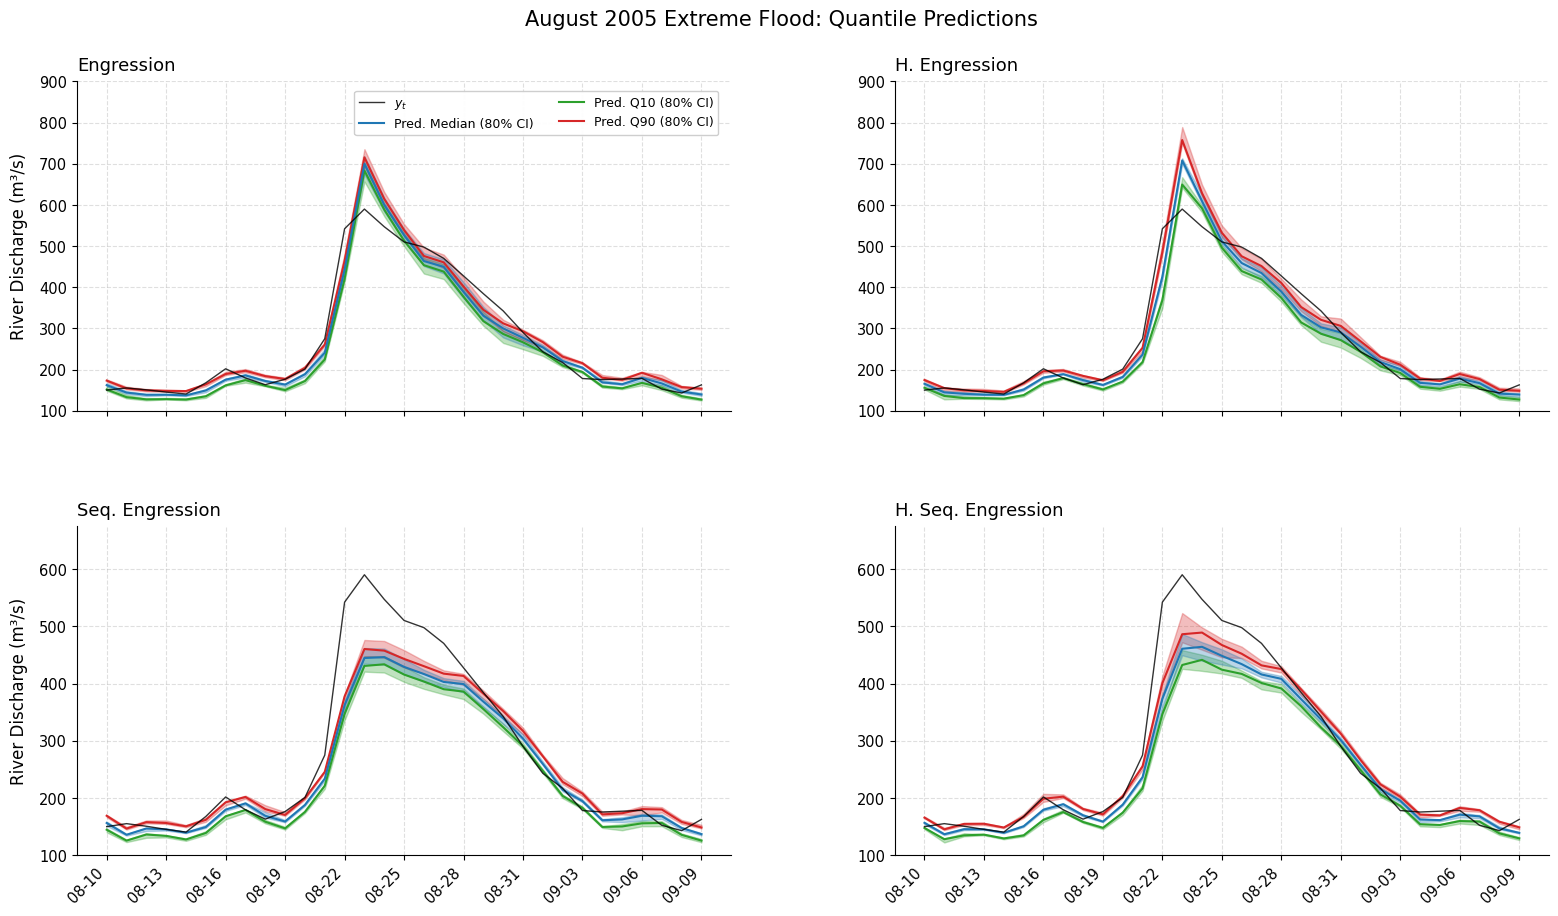

In [22]:
# Window around 2005 peak
start, window = 17256, 31
end = start + window

# Get dates (add back test start index 10349 and lags 10)
data_start = start + 10349 + 10
plot_dates = df.index[data_start:data_start+window]

# Define model configurations
models = [
    ('engression', 'Engression'),
    ('h_engression', 'H. Engression'),
    ('sequential_engression', 'Seq. Engression'),
    ('h_sequential_engression', 'H. Seq. Engression')
]

# Extract true observations (same for all models)
y_true = None

# Create 2x2 subplot grid with slide aspect ratio
fig, axes = plt.subplots(2, 2, figsize=(16, 9))
axes = axes.flatten()

# Adjust spacing
plt.subplots_adjust(hspace=0.35, wspace=0.25, left=0.06, right=0.98, top=0.93, bottom=0.07)

for idx, (model_key, model_name) in enumerate(models):
    ax = axes[idx]
    
    # Extract predictions across all seeds for this model
    q10_preds = []
    q50_preds = []
    q90_preds = []
    
    for seed in seeds:
        key = f'{model_key}_seed{seed}'
        if key in predictions:
            pred_data = predictions[key]
            
            # Extract quantile predictions
            if 'y_pred_q10' in pred_data:
                q10_slice = pred_data['y_pred_q10'][start:end]
                q10_preds.append(np.asarray(q10_slice).ravel())
            if 'y_pred_median' in pred_data:
                q50_slice = pred_data['y_pred_median'][start:end]
                q50_preds.append(np.asarray(q50_slice).ravel())
            if 'y_pred_q90' in pred_data:
                q90_slice = pred_data['y_pred_q90'][start:end]
                q90_preds.append(np.asarray(q90_slice).ravel())
            
            # Extract observations 
            if y_true is None and 'y_true' in pred_data:
                y_true = np.asarray(pred_data['y_true'][start:end]).ravel()
    
    # Check if we have data
    if len(q10_preds) == 0 or len(q50_preds) == 0 or len(q90_preds) == 0:
        print(f"Warning: No data found for {model_name}")
        continue
    
    # Stack arrays and compute statistics
    q10_preds = np.vstack(q10_preds)
    q50_preds = np.vstack(q50_preds)
    q90_preds = np.vstack(q90_preds)
    
    # Compute median across seeds and 80% CI
    q10_median = np.median(q10_preds, axis=0).ravel()
    q10_lower = np.percentile(q10_preds, 10, axis=0).ravel()
    q10_upper = np.percentile(q10_preds, 90, axis=0).ravel()
    
    q50_median = np.median(q50_preds, axis=0).ravel()
    q50_lower = np.percentile(q50_preds, 10, axis=0).ravel()
    q50_upper = np.percentile(q50_preds, 90, axis=0).ravel()
    
    q90_median = np.median(q90_preds, axis=0).ravel()
    q90_lower = np.percentile(q90_preds, 10, axis=0).ravel()
    q90_upper = np.percentile(q90_preds, 90, axis=0).ravel()
    
    # Plot observed values (black line)
    if y_true is not None:
        ax.plot(plot_dates, y_true, color='black', linewidth=1.0, alpha=0.8,
                label='$y_t$', zorder=11)
    
    # Plot predicted quantiles with 80% CI
    # Median (q50) - Blue
    ax.fill_between(plot_dates, q50_lower, q50_upper, alpha=0.3, color='#1f77b4', 
                    zorder=3)
    ax.plot(plot_dates, q50_median, color='#1f77b4', linewidth=1.5, 
            label='Pred. Median (80% CI)', zorder=5)
    
    # 10% quantile - Green
    ax.fill_between(plot_dates, q10_lower, q10_upper, alpha=0.3, color='#2ca02c', 
                    zorder=2)
    ax.plot(plot_dates, q10_median, color='#2ca02c', linewidth=1.5, 
            label='Pred. Q10 (80% CI)', zorder=4)
    
    # 90% quantile - Red
    ax.fill_between(plot_dates, q90_lower, q90_upper, alpha=0.3, color='#d62728', 
                    zorder=2)
    ax.plot(plot_dates, q90_median, color='#d62728', linewidth=1.5, 
            label='Pred. Q90 (80% CI)', zorder=4)
    
    # Labels only on edges
    if idx in [0, 2]:  # Left column
        ax.set_ylabel('River Discharge (m³/s)', fontsize=12, labelpad=8)
    if idx in [2, 3]:  # Bottom row
        ax.xaxis.set_major_formatter(DateFormatter('%m-%d'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    else:
        ax.set_xticklabels([])
    
    ax.set_title(model_name, fontsize=13, pad=8, fontweight='normal', loc='left')
    
    # Grid
    ax.set_axisbelow(True)
    ax.grid(True, which='major', alpha=0.4, linestyle='--')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    
    # Date ticks
    tick_indices = np.arange(0, len(plot_dates), 3)
    ax.set_xticks(plot_dates[tick_indices])
    ax.tick_params(axis='both', labelsize=10.5)
    
    # Flexible y-axis limits
    all_data = np.concatenate([y_true, q10_lower, q10_upper, q50_lower, q50_upper, 
                                q90_lower, q90_upper])
    data_min = np.min(all_data)
    data_max = np.max(all_data)
    
    y_min = np.floor(data_min / 50) * 50
    y_max = np.ceil(data_max / 50) * 50
    y_range = y_max - y_min
    y_max += 0.15 * y_range

    # Force top row to have same scale (up to 900)
    if idx in [0, 1]:  # Top row
        y_max = 900

    ax.set_ylim(y_min, y_max)
    ax.yaxis.set_major_locator(MultipleLocator(100))
    
    # Add legend only to first subplot (top-left)
    if idx == 0:
        ax.legend(loc='upper right', fontsize=9, framealpha=0.95, ncol=2, bbox_to_anchor=(0.99, 0.99))

# Add overall title
fig.suptitle('August 2005 Extreme Flood: Quantile Predictions', 
             fontsize=15, fontweight='normal', y=1.01)

plt.savefig('stochastic_river_quantiles_2x2.png', bbox_inches='tight', dpi=300)
plt.show()

#### <u>**Mean prediction comparison over the peak**</u>

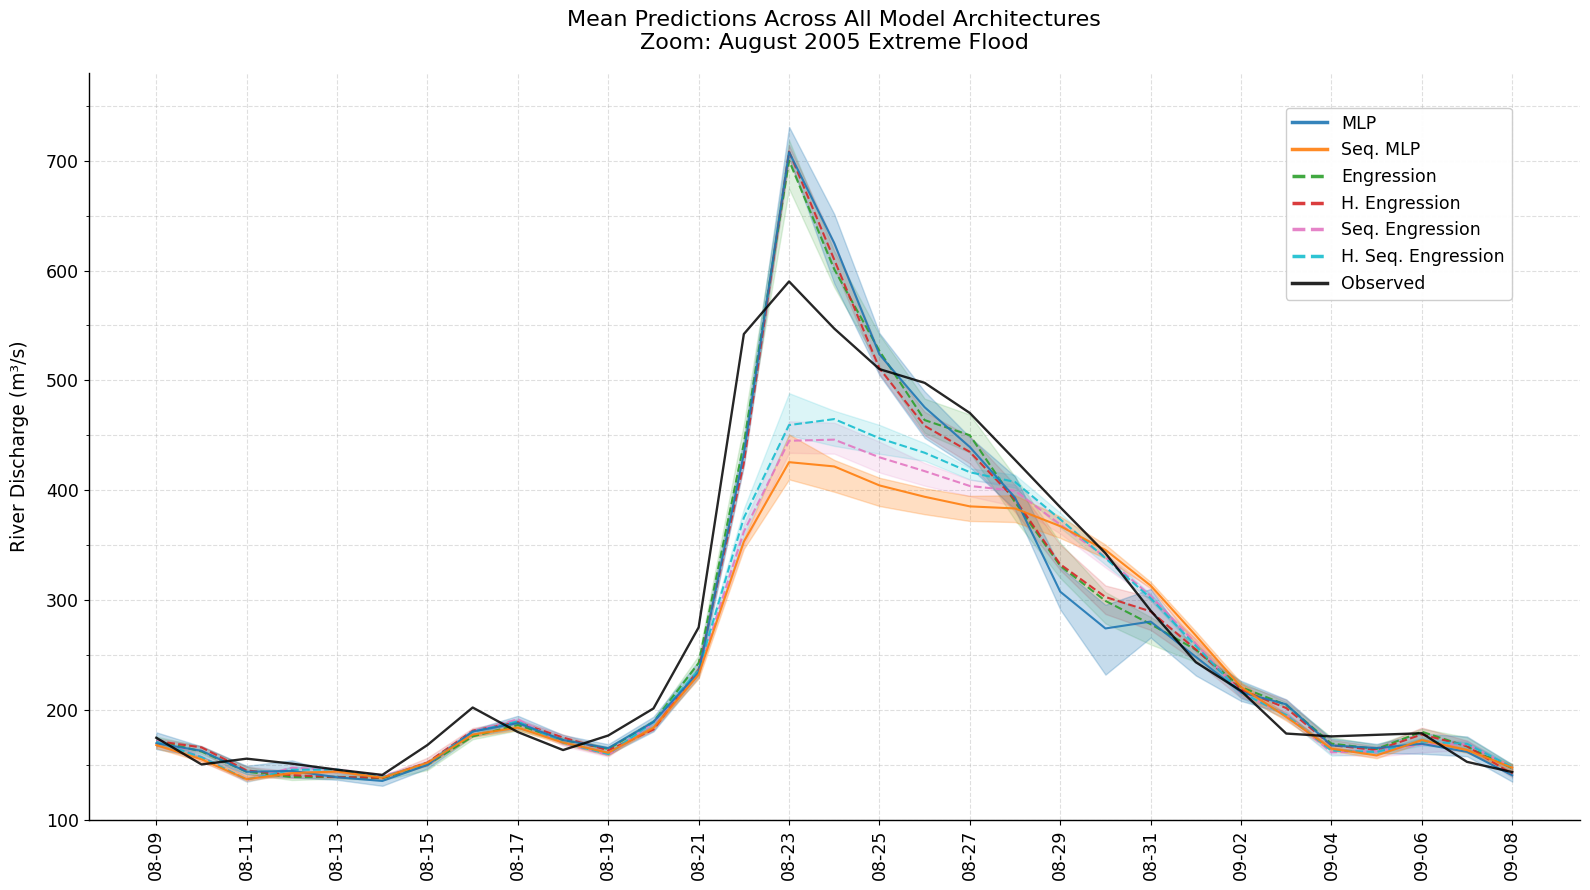

In [13]:
# Window around 2005 peak
start, window = 17255, 31
end = start + window

# Get dates
data_start = start + 10349 + 10
plot_dates = df.index[data_start:data_start+window]

# Define all models with better distinguishable colors
models = [
    ('mlp', 'MLP', '#1f77b4', 'solid', False),                      # Blue
    ('sequential_mlp', 'Seq. MLP', '#ff7f0e', 'solid', False),      # Orange
    ('engression', 'Engression', '#2ca02c', 'dashed', True),        # Green
    ('h_engression', 'H. Engression', '#d62728', 'dashed', True),   # Red
    ('sequential_engression', 'Seq. Engression', '#e377c2', 'dashed', True),  # Pink
    ('h_sequential_engression', 'H. Seq. Engression', '#17becf', 'dashed', True), # Cyan
]

# Extract observations
y_true = None
for seed in seeds:
    key = f'mlp_seed{seed}'
    if key in predictions:
        y_true = np.asarray(predictions[key]['y_true'][start:end]).ravel()
        break

# Create figure with better proportions
fig, ax = plt.subplots(figsize=(16, 9))

# Process each model
for model_key, model_name, color, linestyle, is_stochastic in models:
    mean_preds = []
    
    for seed in seeds:
        key = f'{model_key}_seed{seed}'
        if key in predictions:
            pred_data = predictions[key]
            if 'y_pred' in pred_data:
                mean_slice = pred_data['y_pred'][start:end]
                mean_preds.append(np.asarray(mean_slice).ravel())
    
    if len(mean_preds) == 0:
        continue
    
    mean_preds = np.vstack(mean_preds)
    mean_median = np.median(mean_preds, axis=0).ravel()
    mean_lower = np.percentile(mean_preds, 10, axis=0).ravel()
    mean_upper = np.percentile(mean_preds, 90, axis=0).ravel()
    
    zorder_fill = 1 if is_stochastic else 3
    zorder_line = 4 if is_stochastic else 6
    alpha_fill = 0.15 if is_stochastic else 0.25
    
    ax.fill_between(plot_dates, mean_lower, mean_upper, 
                    alpha=alpha_fill, color=color, zorder=zorder_fill)
    
    ax.plot(plot_dates, mean_median, color=color, linewidth=1.5,
            linestyle=linestyle, label=model_name, zorder=zorder_line, alpha=0.9)

# Plot observations
ax.plot(plot_dates, y_true, color='black', linewidth=1.7, 
        label='Observed', zorder=10, alpha=0.85)

# Formatting
ax.set_ylabel('River Discharge (m³/s)', fontsize=13.5, labelpad=12)
ax.set_title('Mean Predictions Across All Model Architectures\nZoom: August 2005 Extreme Flood',
             fontsize=16, pad=17)

ax.set_axisbelow(True)
ax.grid(True, which='major', alpha=0.4, linestyle='--')
ax.grid(True, which='minor', alpha=0.4, linestyle='--')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.0)
ax.spines['left'].set_linewidth(1.0)

# ticks every 2 days (changed from 5)
tick_indices = np.arange(0, len(plot_dates), 2)
ax.set_xticks(plot_dates[tick_indices])
ax.xaxis.set_major_formatter(DateFormatter('%m-%d'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90, ha='center')
ax.tick_params(axis='both', labelsize=12.5, which='both')

ax.set_ylim(100, 780)
ax.yaxis.set_major_locator(MultipleLocator(100))
ax.yaxis.set_minor_locator(MultipleLocator(50))

# Create custom legend with thicker lines for better color visibility
handles, labels = ax.get_legend_handles_labels()
# Make legend lines thicker
from matplotlib.lines import Line2D
legend_handles = []
for handle, label in zip(handles, labels):
    if isinstance(handle, Line2D):
        # Create thicker line for legend
        new_handle = Line2D([0], [0], color=handle.get_color(), 
                           linewidth=2.5,  
                           linestyle=handle.get_linestyle(),
                           alpha=handle.get_alpha())
        legend_handles.append(new_handle)
    else:
        legend_handles.append(handle)

ax.legend(legend_handles, labels, loc='upper right', fontsize=12.5, 
          framealpha=0.95, ncol=1, bbox_to_anchor=(0.96, 0.965))

plt.tight_layout()
plt.savefig('all_models_mean_predictions.png', bbox_inches='tight', dpi=600)
plt.show()

#### <u>**Prediction vs Observation across models over extreme events**</u>

99.5% threshold: 339.00
Number of extreme observations: 166


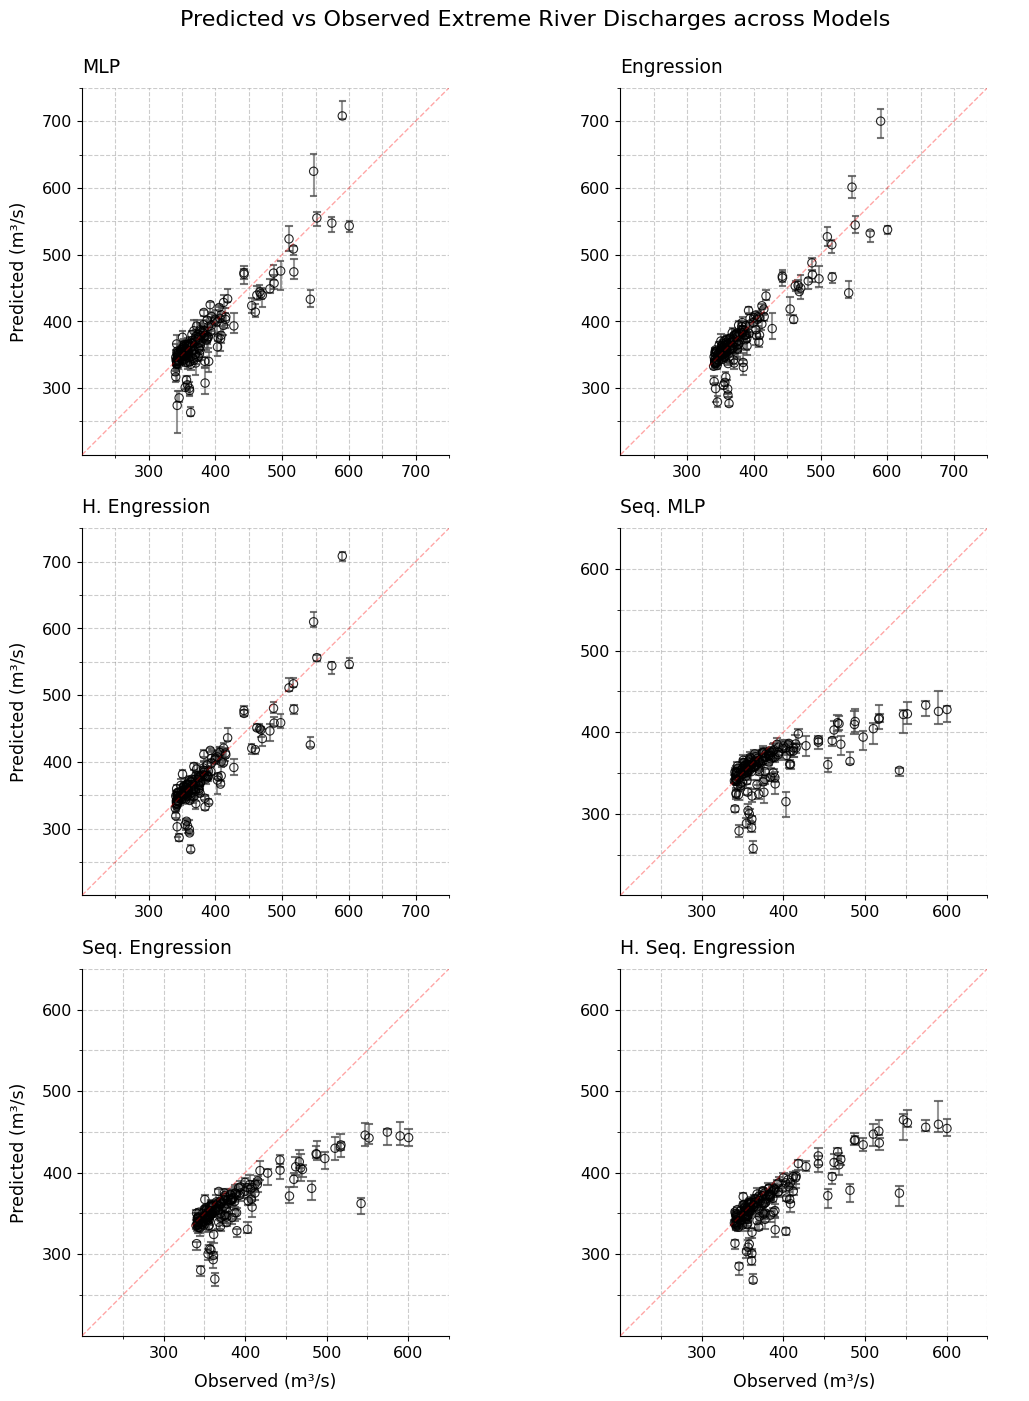

In [12]:
# ============================================================================
train_size = int(len(df_train_val)*0.75)
y_train = df_train_val['Schonau_Q'].values[:train_size]
threshold_99_5 = np.quantile(y_train, 0.995)

# ============================================================================
# Aggregate predictions across seeds for each model
# ============================================================================

model_predictions = {}

for pred_key, pred_data in predictions.items():
    model_name = pred_data['model_name']
    seed = pred_data['seed']
    
    if model_name not in model_predictions:
        model_predictions[model_name] = {
            'y_true': pred_data['y_true'],
            'y_pred_samples': []
        }
    
    y_pred = pred_data['y_pred']
    model_predictions[model_name]['y_pred_samples'].append(y_pred)

# ============================================================================
# Identify extreme observations (>99.5% quantile)
# ============================================================================

first_model = list(model_predictions.keys())[0]
y_true = model_predictions[first_model]['y_true']
extreme_indices = np.where(y_true > threshold_99_5)[0]

print(f"99.5% threshold: {threshold_99_5:.2f}")
print(f"Number of extreme observations: {len(extreme_indices)}")

# ============================================================================
# Define model order and names
# ============================================================================

model_order = [
    'mlp',
    'engression',
    'h_engression',
    'sequential_mlp',
    'sequential_engression',
    'h_sequential_engression'
]

model_display_names = {
    'mlp': 'MLP',
    'engression': 'Engression',
    'h_engression': 'H. Engression',
    'sequential_mlp': 'Seq. MLP',
    'sequential_engression': 'Seq. Engression',
    'h_sequential_engression': 'H. Seq. Engression'
}

# ============================================================================
# Define axis limits for each model type
# ============================================================================

# Static models (MLP, Engression, H. Engression) use wider range
static_models = ['mlp', 'engression', 'h_engression']
axis_limits = {}
for model in model_order:
    if model in static_models:
        axis_limits[model] = (200, 750)
    else:
        axis_limits[model] = (200, 650)

# ============================================================================
# Create scatter plots: predicted vs observed (3 rows, 2 cols)
# ============================================================================

fig = plt.figure(figsize=(12, 13))
gs = fig.add_gridspec(3, 2, width_ratios=[1, 1], hspace=0.2, wspace=0.04,
                      left=0.06, right=0.94, top=0.96, bottom=0.0)
axes = [fig.add_subplot(gs[i, j]) for i in range(3) for j in range(2)]

for plot_idx, model_key in enumerate(model_order):
    if model_key not in model_predictions:
        continue
    
    ax = axes[plot_idx]
    pred_data = model_predictions[model_key]
    
    # Stack predictions across seeds
    y_pred_all_seeds = np.array(pred_data['y_pred_samples'])
    y_true_extreme = y_true[extreme_indices]
    y_pred_extreme = y_pred_all_seeds[:, extreme_indices]
    
    # Calculate statistics across seeds
    y_pred_median = np.median(y_pred_extreme, axis=0).ravel()
    y_pred_q10 = np.percentile(y_pred_extreme, 10, axis=0).ravel()
    y_pred_q90 = np.percentile(y_pred_extreme, 90, axis=0).ravel()
    
    # Get axis limits for this model (unpack the tuple)
    xmin, xmax = axis_limits[model_key]
    ymin, ymax = axis_limits[model_key]  
    
    # Add error whiskers (80% CI) - simple vertical lines
    for xt, yp_median, yp_q10, yp_q90 in zip(y_true_extreme, y_pred_median, y_pred_q10, y_pred_q90):
        ax.plot([xt, xt], [yp_q10, yp_q90], color="#505050", alpha=0.6, 
                linewidth=1.5, zorder=2, solid_capstyle='butt')
        # Add caps
        ax.plot([xt-4, xt+4], [yp_q10, yp_q10], color="#505050", alpha=0.8, 
                linewidth=1.5, zorder=2)
        ax.plot([xt-4, xt+4], [yp_q90, yp_q90], color="#505050", alpha=0.8, 
                linewidth=1.5, zorder=2)
    
    # Plot scatter points with better visibility
    ax.scatter(y_true_extreme, y_pred_median, s=36, alpha=0.85, facecolor='none', edgecolor='black',
                zorder=3, linewidths=0.8)
    
    # Perfect prediction line (diagonal)
    ax.plot([xmin, xmax], [ymin, ymax], '--', linewidth=1.0, 
            alpha=0.35, zorder=12, color='red')
    
    # Set consistent limits for all plots
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect('equal')
    
    # Major ticks at 100-unit intervals (with labels)
    major_ticks = np.arange(300, xmax + 1, 100)
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)
    
    # Minor ticks at 50-unit intervals (without labels)
    minor_ticks = np.arange(250, xmax + 1, 50)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(minor_ticks, minor=True)
    
    # Styling for both major and minor grid (both at 50-unit intervals visually)
    ax.grid(True, which='major', alpha=0.4, linestyle='--', color='gray')
    ax.grid(True, which='minor', alpha=0.4, linestyle='--', color='gray')
    
    # Determine position in grid
    row = plot_idx // 2
    col = plot_idx % 2
    
    # X-axis: Only show axis label for bottom row (row 2), but keep tick numbers for all
    if row < 2:  # Top 4 plots - no axis label
        ax.set_xlabel('')
    else:  # Bottom 2 plots - show axis label
        ax.set_xlabel('Observed (m³/s)', fontsize=12.5, labelpad=9)
    
    # Y-axis: Show label on left column
    if col == 0:  # Left column - visible label on left
        ax.set_ylabel('Predicted (m³/s)', fontsize=12.5, labelpad=10)
    else:  # Right column - invisible label on right for symmetry
        ax.set_ylabel('.', fontsize=20, labelpad=20)
        ax.yaxis.set_label_position("right")
        ax.set_ylabel('Predicted (m³/s)', fontsize=12.5, labelpad=10, color='white')
    
    # Title
    ax.set_title(model_display_names[model_key], fontsize=13.5, pad=11, loc='left')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.tick_params(axis='both', labelsize=11.5)


# Overall title - centered without manual adjustment
fig.suptitle('Predicted vs Observed Extreme River Discharges across Models', 
             fontsize=16, y=1.02)

plt.savefig('river_extreme_predictions_vs_observations.pdf', dpi=600, bbox_inches='tight')
plt.show()